<a href="https://colab.research.google.com/github/Santhosh-RP/CVD/blob/main/cvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
ls

drive/  RFMiD_Training_Labels.csv  sample_data/


In [11]:
%cd /content/drive/MyDrive/images


/content/drive/MyDrive/images


In [16]:
train_dir = '/content/drive/MyDrive/images/san'
labels_file = '/content/RFMiD_Training_Labels.csv'

In [17]:
labels_df = pd.read_csv(labels_file)
labels_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
print(labels_df.columns)


Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
       'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
       'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
      dtype='object')


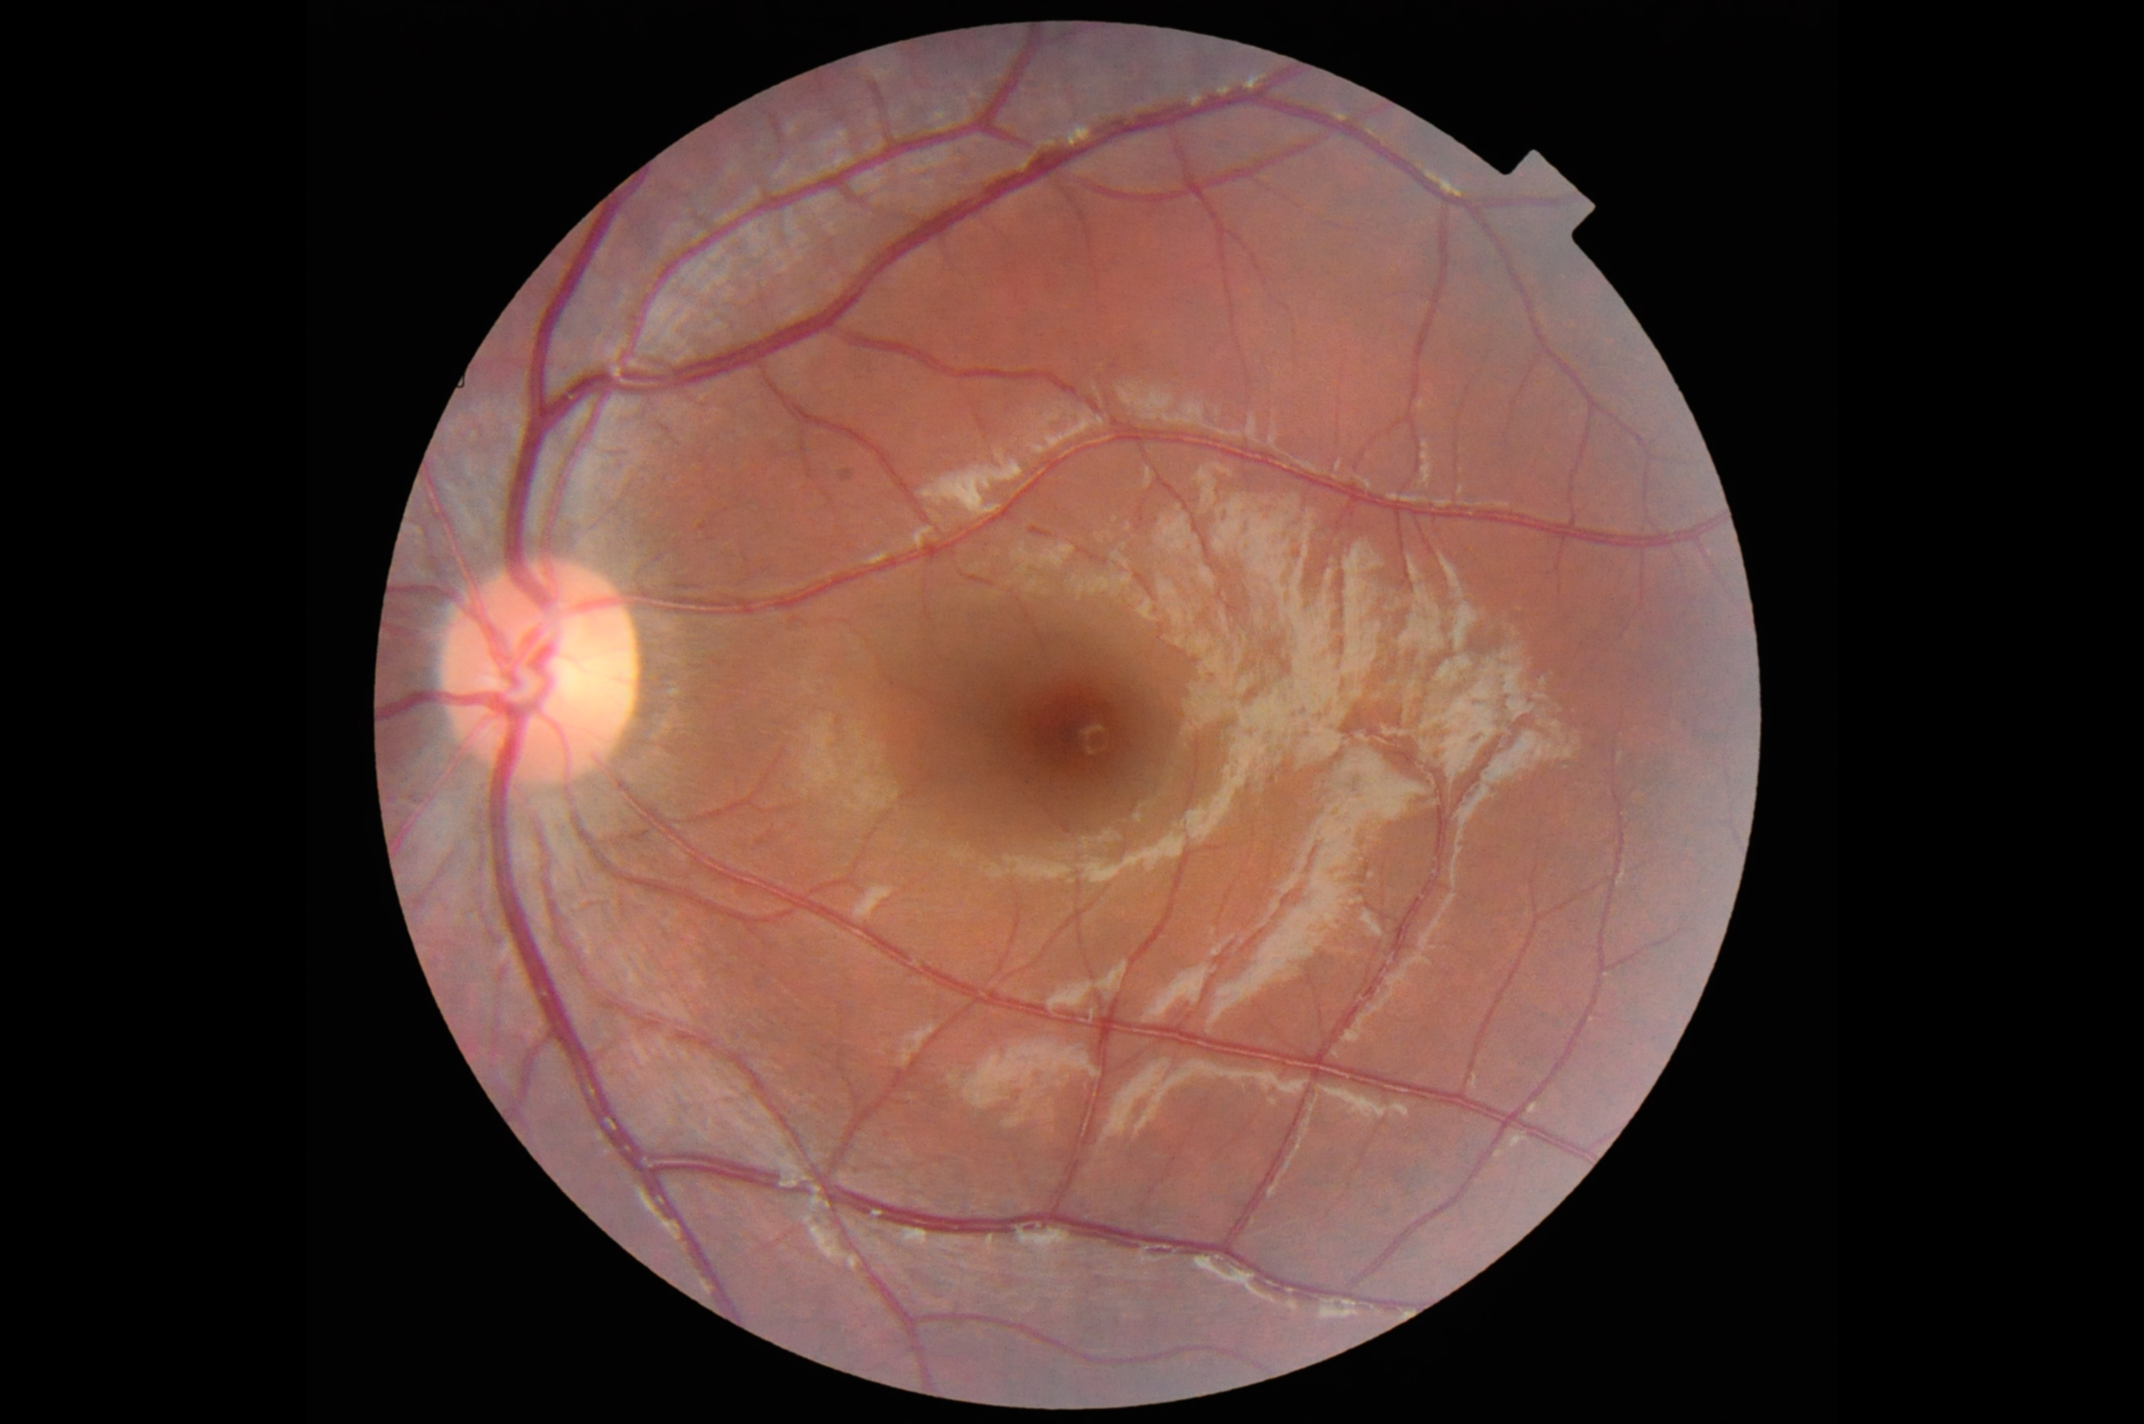

In [19]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/images/san/10.png')
img


In [20]:
class CustomImageDataGenerator(Sequence):
    def __init__(self, dataframe, directory, batch_size=32, image_size=(128, 128), shuffle=True):
        self.dataframe = dataframe
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start_index:end_index]

        batch_x = []
        batch_y = []

        for i in batch_indexes:
            image_id = self.dataframe.iloc[i]['ID']
            image_path = os.path.join(self.directory, f"{image_id}.png")
            label = self.dataframe.iloc[i]['DR']  # Assuming 'DR' column contains labels (0 or 1)

            # Load and preprocess image
            image = Image.open(image_path)
            image = image.resize(self.image_size)
            image = np.array(image) / 255.0  # Normalize pixel values

            batch_x.append(image)
            batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [27]:
# Path to your dataset CSV file
dataset_file = '/content/RFMiD_Training_Labels.csv'

# Path to directory containing image files
image_directory = '/content/drive/MyDrive/images/san'

# Load dataset from CSV file
dataset = pd.read_csv(dataset_file).head(20)

# Split dataset into training and validation sets
train_df = dataset.sample(frac=0.8, random_state=42)
valid_df = dataset.drop(train_df.index)

# Create custom data generators
train_generator = CustomImageDataGenerator(train_df, image_directory)
valid_generator = CustomImageDataGenerator(valid_df, image_directory)


In [28]:
# Build your CNN model (similar to previous examples)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using custom data generators
model.fit(train_generator, epochs=5, validation_data=valid_generator)


Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.6894 - accuracy: 0.5625 - val_loss: 0.0784 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 1.0316 - accuracy: 0.5625 - val_loss: 0.8115 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.7159 - accuracy: 0.4375 - val_loss: 0.9584 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.7615 - accuracy: 0.4375 - val_loss: 0.7595 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.7005 - accuracy: 0.4375 - val_loss: 0.6421 - val_accuracy: 1.0000


In [29]:
model=model.save('abc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
from flask import Flask, render_template, request
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = os.path.join(os.getcwd(), 'uploads')  # Full path to 'uploads' directory
app.config['ALLOWED_EXTENSIONS'] = {'png', 'jpg', 'jpeg'}

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

def preprocess_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    if request.method == 'POST':
        if 'image_file' not in request.files:
            return render_template('index.html', prediction="No file uploaded")

        file = request.files['image_file']
        if file.filename == '':
            return render_template('index.html', prediction="No file selected")

        if file and allowed_file(file.filename):
            filename = file.filename
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)

            # Create the 'uploads' directory if it doesn't exist
            os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

            file.save(file_path)

            # Specify the path to your trained model
            model_filename = 'your_trained_model.h5'
            model_path = os.path.join('app', 'model', model_filename)  # Adjust path as needed

            # Check if the model file exists
            if not os.path.exists(model_path):
                return render_template('index.html', prediction="Model file not found")

            # Load the trained model and make predictions
            model = load_model(model_path)

            # Preprocess the uploaded image and make prediction
            preprocessed_image = preprocess_image(file_path)
            prediction_score = model.predict(preprocessed_image)
            prediction = "Diabetic Retinopathy (DR)" if prediction_score >= 0.5 else "No Diabetic Retinopathy"

    return render_template('index.html', prediction=prediction)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
